# Human Activity Recognition
    
This project is to build a model that predicts the human activities such as Walking, Walking_Upstairs, Walking_Downstairs, Sitting, Standing or Laying.
    
The [dataset](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones) used in this project is obtained from UCI Machine Learning Repository.

This dataset is collected from 30 persons(referred as subjects in this dataset), performing different activities with a smartphone to their waists. The data is recorded with the help of sensors (accelerometer and Gyroscope) in that smartphone. This experiment was video recorded to label the data manually.

## Quick overview of the dataset :    
    
* Accelerometer and Gyroscope readings are taken from 30 volunteers(referred as subjects) while performing the following 6 Activities.

    1. Walking     
    2. WalkingUpstairs 
    3. WalkingDownstairs 
    4. Standing 
    5. Sitting 
    6. Lying.


* Readings are divided into a window of 2.56 seconds with 50% overlapping. 

* Accelerometer readings are divided into gravity acceleration and body acceleration readings,
  which has x,y and z components each.

* Gyroscope readings are the measure of angular velocities which has x,y and z components.

* Jerk signals are calculated for BodyAcceleration readings.

* Fourier Transforms are made on the above time readings to obtain frequency readings.

* Now, on all the base signal readings., mean, max, mad, sma, arcoefficient, engerybands,entropy etc., are calculated for each window.

* We get a feature vector of 561 features and these features are given in the dataset.

* Each window of readings is a datapoint of 561 features.

### Problem Framework

* 30 subjects(volunteers) data is randomly split to 70%(21) train and 30%(9) test data.
* Each datapoint corresponds one of the 6 Activities.
    
### Problem Statement

* Given a new datapoint we have to predict the Activity
    
> First of all we will try to apply Classical Machine Learning models on the data set having features engineered by domain experts (signal processed data), and later we will try to apply Deep Learning models on direct raw data.

## Imports

In [1]:
# data analysis
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "Dejavu Sans"

# t-SNE
from sklearn.manifold import TSNE

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# grid search (hyperparameters tuning)
from sklearn.model_selection import GridSearchCV

# classification metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# RNNs [LSTM]
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# misc.
import itertools
from datetime import datetime
import joblib # to save ml models
import warnings

warnings.filterwarnings("ignore")

physical_devices = tf.config.experimental.list_physical_devices("GPU")
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

# path to the data set
path = "./UCI HAR Dataset/" 

## Obtaining train and test data

In [2]:
# Obtaing features from features.txt file
with open("./UCI HAR Dataset/features.txt") as f:
    features = [line.split()[1] for line in f.readlines()]
print(f"Number of Features: {len(features)}")

Number of Features: 561


In [3]:
names = []
for idx, feature in enumerate(features):
    if feature not in names:
        names.append(feature)
    else:
        feature = feature+"_"+str(idx)
        names.append(feature)

In [4]:
X_train = pd.read_csv("./UCI HAR Dataset/train/X_train.txt", names=names, header=None, delim_whitespace=True)

X_train["subject"] = pd.read_csv("./UCI HAR Dataset/train/subject_train.txt", header=None, squeeze=True)

y_train = pd.read_csv("./UCI HAR Dataset/train/y_train.txt", names=["Activity"], squeeze=True)

y_train_labels = y_train.map({1: "WALKING", 2: "WALKING_UPSTAIRS", 3: "WALKING_DOWNSTAIRS", 
                              4: "SITTING", 5: "STANDING", 6: "LAYING"})

# Putting all columns in single dataframe
train = X_train
train["activity"] = y_train
train["activity_name"] = y_train_labels

train.sample()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,activity,activity_name
328,0.260012,-0.030019,-0.109704,-0.298833,-0.012421,0.007633,-0.358174,-0.043513,0.062007,-0.109494,...,0.083336,0.127141,0.982324,-0.216229,-0.620312,0.351139,0.086802,1,2,WALKING_UPSTAIRS


In [5]:
X_test = pd.read_csv("UCI HAR Dataset/test/X_test.txt", names=names, header=None, delim_whitespace=True)

X_test["subject"] = pd.read_csv("UCI HAR Dataset/test/subject_test.txt", header=None, squeeze=True)

y_test = pd.read_csv("UCI HAR Dataset/test/y_test.txt", names=["Activity"], squeeze=True)

y_test_labels = y_test.map({1: "WALKING", 2: "WALKING_UPSTAIRS", 3: "WALKING_DOWNSTAIRS", 
                            4: "SITTING", 5: "STANDING", 6: "LAYING"})

# Putting all columns in single dataframe
test = X_test
test["activity"] = y_test
test["activity_name"] = y_test_labels

test.sample()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,activity,activity_name
752,0.270646,-0.00016,-0.007428,0.1817,0.222918,-0.051702,0.064677,0.125091,-0.086623,0.540265,...,0.067455,0.45504,-0.22907,-0.146988,-0.913846,0.152839,0.042913,9,3,WALKING_DOWNSTAIRS


In [6]:
train.shape, test.shape

((7352, 564), (2947, 564))

## Data Cleaning

### 1. Checking for Duplicates

In [7]:
print(f"Number of duplicates in train set: {train.duplicated().sum()}")
print(f"Number of duplicates in test set : {test.duplicated().sum()}")

Number of duplicates in train set: 0
Number of duplicates in test set : 0


### 2. Checking for NaN/null values

In [8]:
print(f"NaN/null values in train set: {train.isnull().values.sum()}")
print(f"NaN/null values in test set : {test.isnull().values.sum()}")

NaN/null values in train set: 0
NaN/null values in test set : 0


### 3. Checking for imbalance data

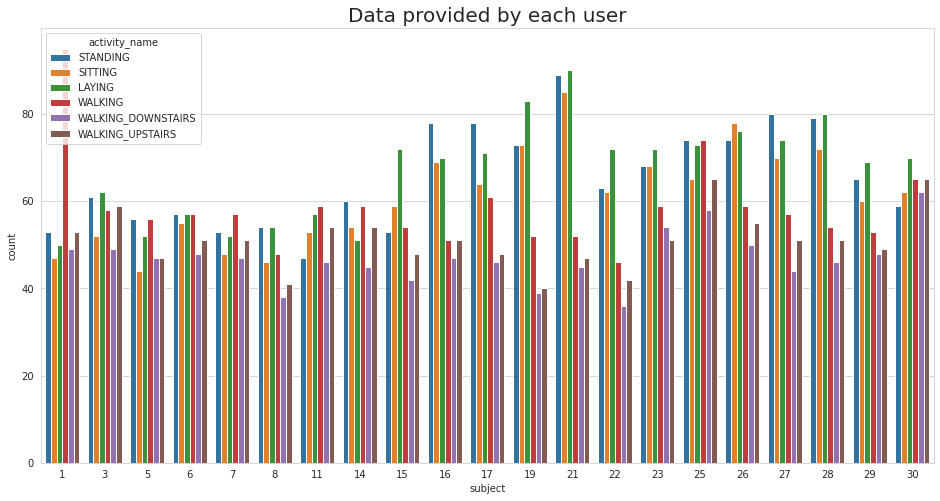

In [9]:
plt.figure(figsize=(16, 8))
plt.title("Data provided by each user", fontsize=20)
sns.countplot(x="subject", hue="activity_name", data=train)
plt.show()

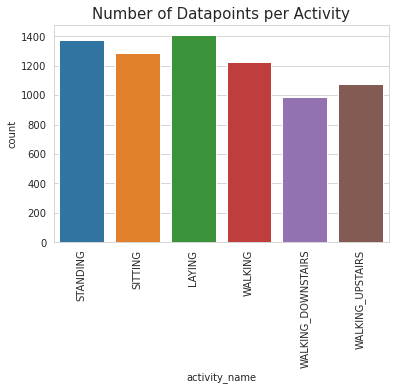

In [10]:
plt.title("Number of Datapoints per Activity", fontsize=15)
sns.countplot("activity_name", data=train)
plt.xticks(rotation=90)
plt.show()

>**The data is almost well balanced.**

### 4. Changing feature names

In [11]:
columns = train.columns

# Removing '()', ',', '-' from column names
columns = columns.str.replace("[()]", "")
columns = columns.str.replace(",", "")
columns = columns.str.replace("-", "")

train.columns = columns
test.columns = columns

train.columns

Index(['tBodyAccmeanX', 'tBodyAccmeanY', 'tBodyAccmeanZ', 'tBodyAccstdX',
       'tBodyAccstdY', 'tBodyAccstdZ', 'tBodyAccmadX', 'tBodyAccmadY',
       'tBodyAccmadZ', 'tBodyAccmaxX',
       ...
       'angletBodyAccMeangravity', 'angletBodyAccJerkMeangravityMean',
       'angletBodyGyroMeangravityMean', 'angletBodyGyroJerkMeangravityMean',
       'angleXgravityMean', 'angleYgravityMean', 'angleZgravityMean',
       'subject', 'activity', 'activity_name'],
      dtype='object', length=564)

### 5. Saving this dataframe to a csv file

In [12]:
train.to_csv("./UCI HAR Dataset/csv_files/train.csv", index=False)
test.to_csv("./UCI HAR Dataset/csv_files/test.csv", index=False)

## Exploratory Data Analysis

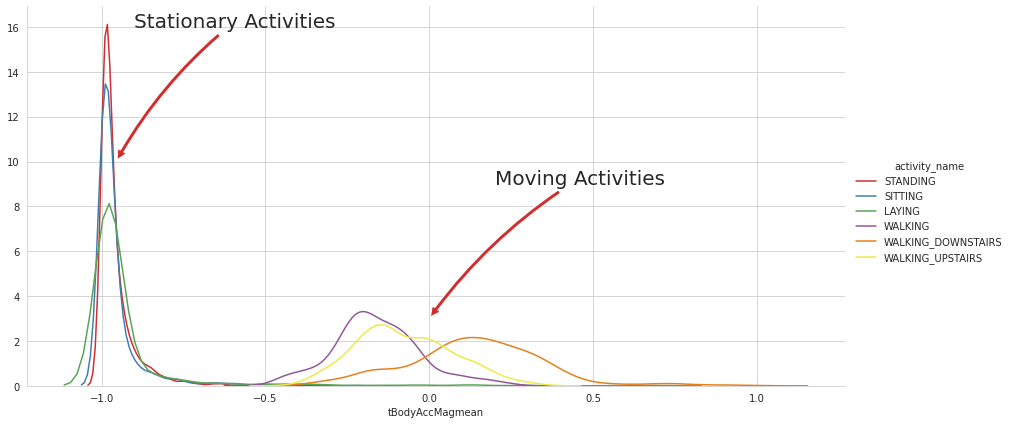

In [13]:
sns.set_palette("Set1", desat=0.8)
facetgrid = sns.FacetGrid(train, hue="activity_name", height=6, aspect=2)
facetgrid.map(sns.distplot,'tBodyAccMagmean', hist=False).add_legend()
plt.annotate("Stationary Activities", xy=(-0.956,10), xytext=(-0.9, 16), size=20,
            arrowprops=dict(arrowstyle="simple",connectionstyle="arc3,rad=0.1"))

plt.annotate("Moving Activities", xy=(0,3), xytext=(0.2, 9), size=20,
            arrowprops=dict(arrowstyle="simple",connectionstyle="arc3,rad=0.1"))
plt.show()

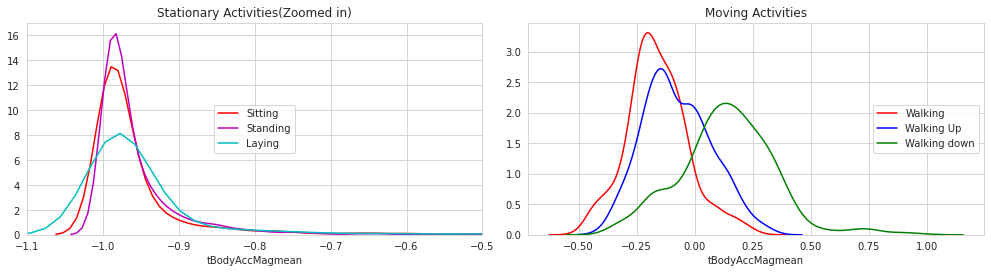

In [14]:
# For plotting purposes taking datapoints of each activity to a different dataframe
df1 = train[train["activity"]==1]
df2 = train[train["activity"]==2]
df3 = train[train["activity"]==3]
df4 = train[train["activity"]==4]
df5 = train[train["activity"]==5]
df6 = train[train["activity"]==6]

plt.figure(figsize=(14, 7))
plt.subplot(2, 2, 1)
plt.title("Stationary Activities(Zoomed in)")
sns.distplot(df4["tBodyAccMagmean"],color="r", hist=False, label="Sitting")
sns.distplot(df5["tBodyAccMagmean"],color="m", hist=False, label="Standing")
sns.distplot(df6["tBodyAccMagmean"],color="c", hist=False, label="Laying")
plt.axis([-1.1, -0.5, 0, 17])
plt.legend(loc="center")

plt.subplot(2, 2, 2)
plt.title("Moving Activities")
sns.distplot(df1["tBodyAccMagmean"],color="red", hist=False, label="Walking")
sns.distplot(df2["tBodyAccMagmean"],color="blue", hist=False,label="Walking Up")
sns.distplot(df3["tBodyAccMagmean"],color="green", hist=False, label="Walking down")
plt.legend(loc="center right")


plt.tight_layout()
plt.show()

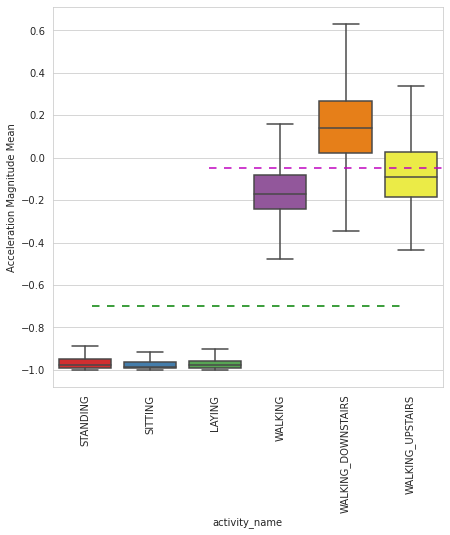

In [15]:
plt.figure(figsize=(7, 7))
sns.boxplot(x="activity_name", y="tBodyAccMagmean", data=train, showfliers=False, saturation=1)
plt.ylabel("Acceleration Magnitude Mean")
plt.axhline(y=-0.7, xmin=0.1, xmax=0.9, dashes=(5, 5), c="g")
plt.axhline(y=-0.05, xmin=0.4, dashes=(5, 5), c="m")
plt.xticks(rotation=90)
plt.show()

- if tAccmean is < -0.7 than the activities are either Standing, Sitting or Laying.
- if tAccmean > -0.6 than the activities are either Walking, WalkingDownstairs or WalkingUpstairs.
- if tAccmean is > 0.0 than the activity is WalkingDownstairs.

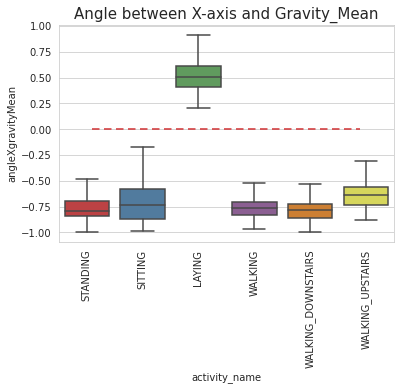

In [16]:
sns.boxplot(x="activity_name", y="angleXgravityMean", showfliers=False, data=train)
plt.axhline(y=0.0, xmin=0.1, xmax=0.9, dashes=(5, 3))
plt.title("Angle between X-axis and Gravity_Mean", fontsize=15)
plt.xticks(rotation=90)
plt.show()

- If angleXgravitymean > 0 than activity is Laying.
- We can classify all datapoints to Laying activity with just a single if else statement.

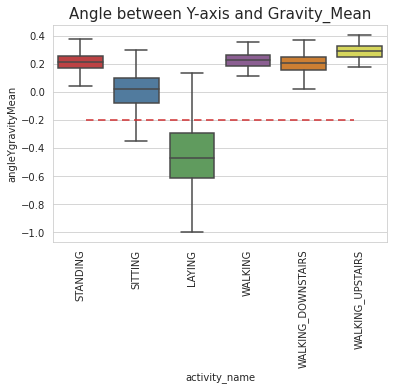

In [17]:
sns.boxplot(x="activity_name", y="angleYgravityMean", showfliers=False, data=train)
plt.axhline(y=-0.2, xmin=0.1, xmax=0.9, dashes=(5, 3))
plt.title("Angle between Y-axis and Gravity_Mean", fontsize=15)
plt.xticks(rotation=90)
plt.show()

## Applying t-sne on the data

In [18]:
def perform_tsne(X, y, perplexities, n_iter=1000):
    
    for idx, perplexity in enumerate(perplexities):
        
        print(f"\nPerforming t-SNE with perplexity {perplexity} and with {n_iter} iterations at max")
        X_reduced = TSNE(perplexity=perplexity, verbose=1).fit_transform(X)
        print("Done...")
        
        print("t-SNE visualization...")
        df = pd.DataFrame({"x": X_reduced[:, 0], "y": X_reduced[:, 1], "label": y})
        
        sns.lmplot(data=df, x="x", y="y", hue="label", fit_reg=False, size=8,
                   palette="Set1", markers=["^", "v", "s", "o", "1", "2"])
        plt.title(f"perplexity: {perplexity} and max_iter: {n_iter}")
        plt.show()
        print("Done")


Performing t-SNE with perplexity 2 and with 1000 iterations at max
[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.866s...
[t-SNE] Computed neighbors for 7352 samples in 32.743s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 0.635854
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.027000
[t-SNE] KL divergence after 1000 iterations: 1.626400
Done...
t-SNE visualization...


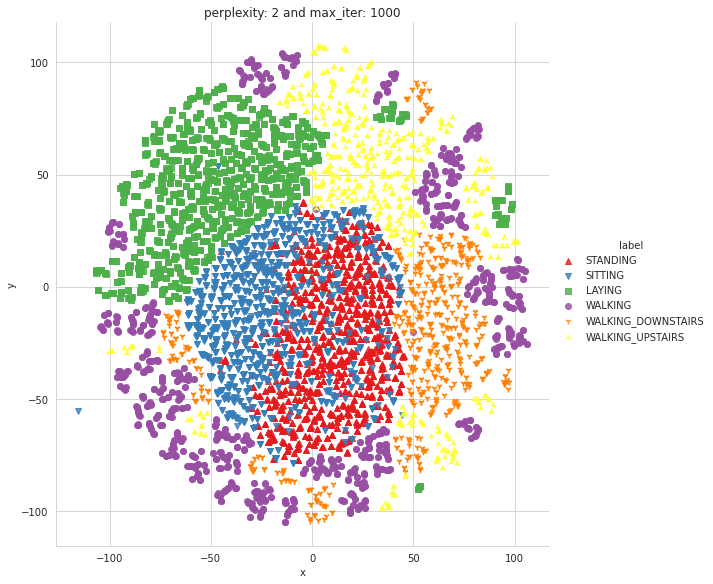

Done

Performing t-SNE with perplexity 5 and with 1000 iterations at max
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.809s...
[t-SNE] Computed neighbors for 7352 samples in 31.395s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 0.961265
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.181984
[t-SNE] KL divergence after 1000 iterations: 1.571247
Done...
t-SNE visualization...


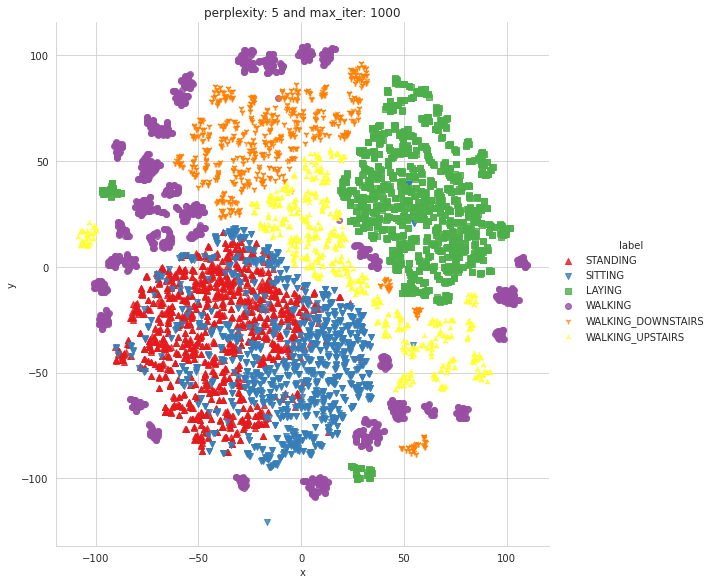

Done

Performing t-SNE with perplexity 10 and with 1000 iterations at max
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.808s...
[t-SNE] Computed neighbors for 7352 samples in 31.948s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.133828
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.519135
[t-SNE] KL divergence after 1000 iterations: 1.505614
Done...
t-SNE visualization...


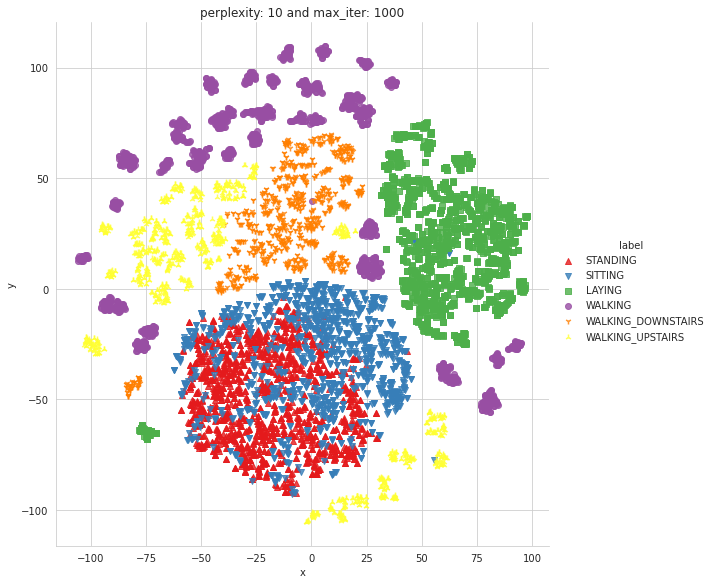

Done

Performing t-SNE with perplexity 20 and with 1000 iterations at max
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.804s...
[t-SNE] Computed neighbors for 7352 samples in 32.651s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.274335
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.765869
[t-SNE] KL divergence after 1000 iterations: 1.419444
Done...
t-SNE visualization...


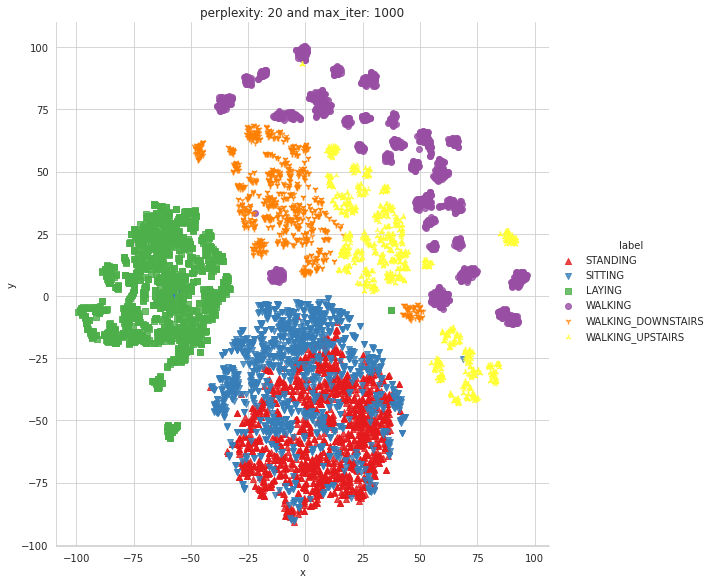

Done

Performing t-SNE with perplexity 50 and with 1000 iterations at max
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.900s...
[t-SNE] Computed neighbors for 7352 samples in 36.519s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.437672
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.135345
[t-SNE] KL divergence after 1000 iterations: 1.283223
Done...
t-SNE visualization...


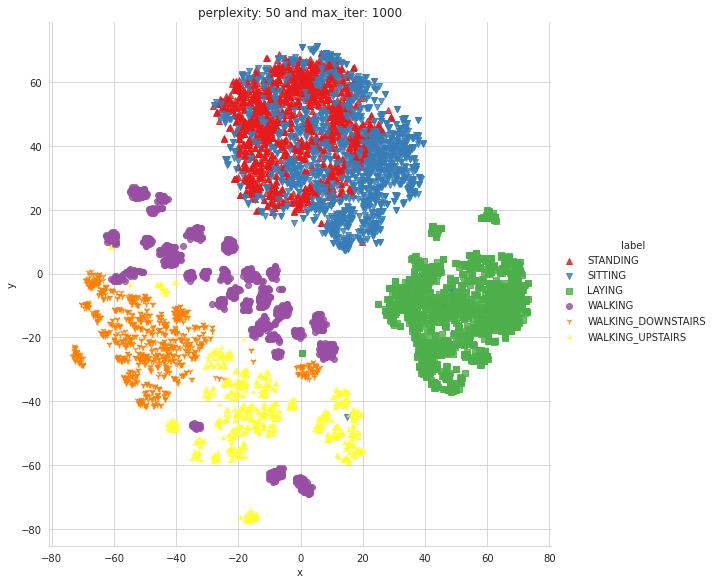

Done


In [19]:
X_pre_tsne = train.drop(["subject", "activity", "activity_name"], axis=1)
y_pre_tsne = train["activity_name"]
perform_tsne(X_pre_tsne, y_pre_tsne, perplexities=[2, 5, 10, 20, 50])

- All labels except Standing and Sitting can be easily seperated through t-SNE.

## Splitting features and labels from train and test data set

In [20]:
# reading train and test data sets from csv files
train = pd.read_csv("./UCI HAR Dataset/csv_files/train.csv")
test = pd.read_csv("./UCI HAR Dataset/csv_files/test.csv")

X_train = train.drop(["subject", "activity", "activity_name"], axis=1)
y_train = train["activity_name"]

X_test = test.drop(["subject", "activity", "activity_name"], axis=1)
y_test = test["activity_name"]

## Data Modelling

In [21]:
labels = ["LAYING", "SITTING", "STANDING", "WALKING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS"]

In [22]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, figsize=(8, 8), normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized Confusion Matrix"

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.grid(b=False)
    ax.set(title=title,
        xlabel="Predicted Labels",
        ylabel="True Labels")
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=90)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)
    
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()

In [23]:
# Generic function to run any classical ml model specified
def perform_model(model, X_train, y_train, X_test, y_test, class_labels, cm_normalize=True, print_cm=True, cm_cmap=plt.cm.Greens):
    
    results = dict()
    
    # time at which model starts training
    train_start_time = datetime.now()
    print("training the model...")
    model.fit(X_train, y_train)
    print("Done \n \n")
    train_end_time = datetime.now()
    results["training_time"] = train_end_time - train_start_time
    print(f"training_time(HH:MM:SS.ms) - {results['training_time']} \n \n")
    
    # predict test data
    print("predicting test data")
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    print("Done \n \n")
    results["testing_time"] = test_end_time - test_start_time
    print(f"testing_time(HH:MM:SS.ms) - {results['testing_time']} \n \n")
    results["predicted"] = y_pred
    
    # calculate overall accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    results["accuracy"] = accuracy
    print(f"ACCURACY: {accuracy * 100:.2f}%\n\n")
    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    results["confusion_matrix"] = cm
    if print_cm:
        print("CONFUSION MATRIX\n")
        print(f"{cm}")
        
    # plot confusion matrix
    print("\n")
    plot_confusion_matrix(cm, classes=class_labels, normalize=cm_normalize, cmap=cm_cmap)
    plt.show()
    print("\n")
    
    # classification report
    print("CLASSIFICATION REPORT\n")
    cf_report = classification_report(y_test, y_pred)
    results["classification_report"] = cf_report
    print(cf_report)
    
    # adding trained model to results
    results["model"] = model
    
    return results

In [24]:
# function to print gridsearch attributes
def print_grid_search_attributes(model):
    
    # best estimator
    print("BEST ESTIMATOR")
    print(f"\n\t{model.best_estimator_}\n\n\t")
    
    # best parameters
    print("BEST PARAMETERS")
    print(f"\n\tParameters of best estimator: {model.best_params_}\n\n\t")
    
    # number of cross validation splits
    print("NO. OF CROSS VALIDATION SPLITS")
    print(f"\n\tTotal number of cross validation sets: {model.n_splits_}\n\n\t")
    
    # average cross validated score of the best estimator, from the grid search
    print("BEST SCORE")
    print(f"\n\tAverage cross validated scores of best estimator: {model.best_score_}\n\n\t")

In [25]:
# function to save models
def save_model(models):
    for model_name, model in models.items():
        joblib.dump(model, f"./models/{model_name}.pkl")

### Logistic Regression with Grid Search

training the model...
Done 
 

training_time(HH:MM:SS.ms) - 0:00:52.839318 
 

predicting test data
Done 
 

testing_time(HH:MM:SS.ms) - 0:00:00 
 

ACCURACY: 95.89%


CONFUSION MATRIX

[[537   0   0   0   0   0]
 [  1 427  61   0   0   2]
 [  0  13 519   0   0   0]
 [  0   0   0 493   2   1]
 [  0   0   0   5 403  12]
 [  0   0   0  22   2 447]]




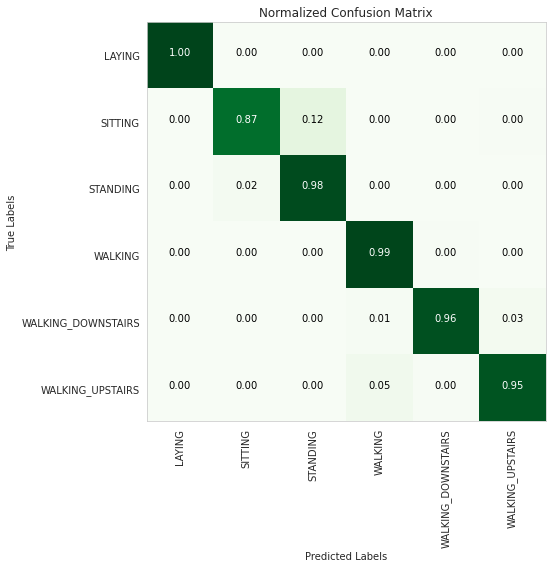



CLASSIFICATION REPORT

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.97      0.87      0.92       491
          STANDING       0.89      0.98      0.93       532
           WALKING       0.95      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.96      0.97       420
  WALKING_UPSTAIRS       0.97      0.95      0.96       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



In [26]:
grid_params = {"C": [0.01, 0.1, 1, 10, 20, 30], "penalty": ["l1", "l2"]}
log_reg = LogisticRegression()
log_reg_grid = GridSearchCV(log_reg, param_grid=grid_params, cv=10, n_jobs=-1)
log_reg_grid_results = perform_model(log_reg_grid, X_train, y_train, X_test, y_test, class_labels=labels)

In [27]:
# observing attributes of the model
print_grid_search_attributes(log_reg_grid_results["model"])

BEST ESTIMATOR

	LogisticRegression(C=10)

	
BEST PARAMETERS

	Parameters of best estimator: {'C': 10, 'penalty': 'l2'}

	
NO. OF CROSS VALIDATION SPLITS

	Total number of cross validation sets: 10

	
BEST SCORE

	Average cross validated scores of best estimator: 0.9455998595090209

	


### LinearSVC with Grid Search

training the model...
Done 
 

training_time(HH:MM:SS.ms) - 0:01:43.724812 
 

predicting test data
Done 
 

testing_time(HH:MM:SS.ms) - 0:00:00 
 

ACCURACY: 96.50%


CONFUSION MATRIX

[[537   0   0   0   0   0]
 [  2 423  62   0   0   4]
 [  0  10 521   1   0   0]
 [  0   0   0 496   0   0]
 [  0   0   0   2 413   5]
 [  0   0   0  17   0 454]]




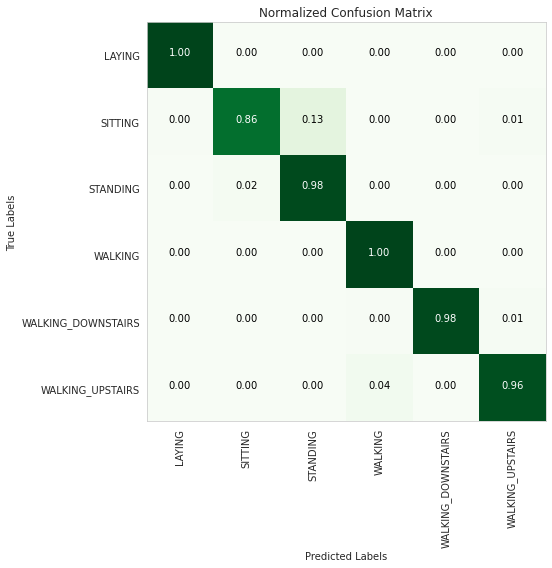



CLASSIFICATION REPORT

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.98      0.86      0.92       491
          STANDING       0.89      0.98      0.93       532
           WALKING       0.96      1.00      0.98       496
WALKING_DOWNSTAIRS       1.00      0.98      0.99       420
  WALKING_UPSTAIRS       0.98      0.96      0.97       471

          accuracy                           0.97      2947
         macro avg       0.97      0.96      0.97      2947
      weighted avg       0.97      0.97      0.96      2947

BEST ESTIMATOR

	LinearSVC(C=1, tol=5e-05)

	
BEST PARAMETERS

	Parameters of best estimator: {'C': 1}

	
NO. OF CROSS VALIDATION SPLITS

	Total number of cross validation sets: 10

	
BEST SCORE

	Average cross validated scores of best estimator: 0.9513104480922804

	


In [28]:
grid_params = {"C": [0.125, 0.5, 1, 2, 8, 16]}
lr_svc = LinearSVC(tol=0.00005)
lr_svc_grid = GridSearchCV(lr_svc, param_grid=grid_params, cv=10, n_jobs=-1)
lr_svc_grid_results = perform_model(lr_svc_grid, X_train, y_train, X_test, y_test, class_labels=labels)
print_grid_search_attributes(lr_svc_grid_results["model"])

### Kernel SVM with Grid Search

training the model...
Done 
 

training_time(HH:MM:SS.ms) - 0:16:24.401845 
 

predicting test data
Done 
 

testing_time(HH:MM:SS.ms) - 0:00:01.996587 
 

ACCURACY: 96.27%


CONFUSION MATRIX

[[537   0   0   0   0   0]
 [  0 441  48   0   0   2]
 [  0  12 520   0   0   0]
 [  0   0   0 489   2   5]
 [  0   0   0   4 397  19]
 [  0   0   0  17   1 453]]




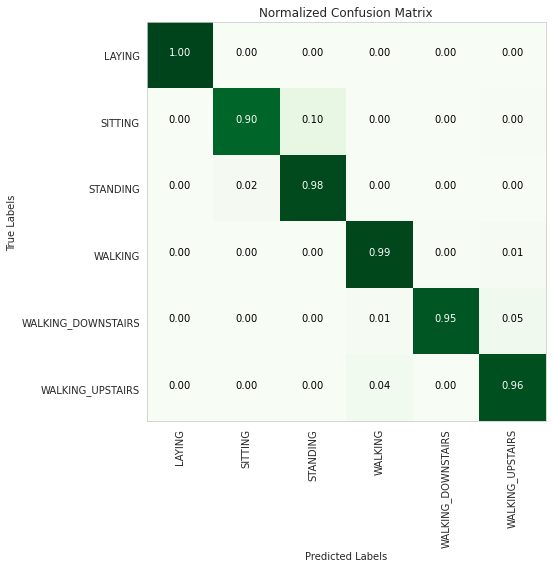



CLASSIFICATION REPORT

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.97      0.90      0.93       491
          STANDING       0.92      0.98      0.95       532
           WALKING       0.96      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.95      0.97       420
  WALKING_UPSTAIRS       0.95      0.96      0.95       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947

BEST ESTIMATOR

	SVC(C=16, gamma=0.0078125)

	
BEST PARAMETERS

	Parameters of best estimator: {'C': 16, 'gamma': 0.0078125}

	
NO. OF CROSS VALIDATION SPLITS

	Total number of cross validation sets: 10

	
BEST SCORE

	Average cross validated scores of best estimator: 0.9571609730848861

	


In [29]:
grid_params = {"C": [2, 8, 16], "gamma": [0.0078125, 0.125, 2]}
rbf_svm = SVC(kernel="rbf")
rbf_svm_grid = GridSearchCV(rbf_svm, param_grid=grid_params, cv=10, n_jobs=-1)
rbf_svm_grid_results = perform_model(rbf_svm_grid, X_train, y_train, X_test, y_test, class_labels=labels)
print_grid_search_attributes(rbf_svm_grid_results["model"])

### Decision Trees with Grid Search

training the model...
Done 
 

training_time(HH:MM:SS.ms) - 0:00:09.684146 
 

predicting test data
Done 
 

testing_time(HH:MM:SS.ms) - 0:00:00.015622 
 

ACCURACY: 87.68%


CONFUSION MATRIX

[[537   0   0   0   0   0]
 [  0 373 118   0   0   0]
 [  0  59 473   0   0   0]
 [  0   0   0 472  18   6]
 [  0   0   0  22 352  46]
 [  0   0   0  67  27 377]]




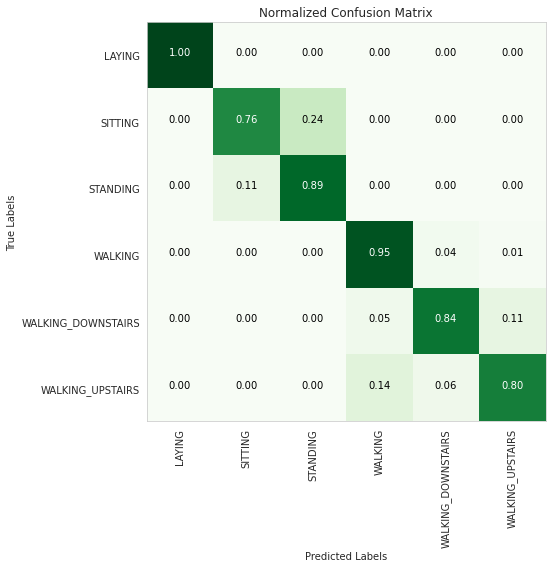



CLASSIFICATION REPORT

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.86      0.76      0.81       491
          STANDING       0.80      0.89      0.84       532
           WALKING       0.84      0.95      0.89       496
WALKING_DOWNSTAIRS       0.89      0.84      0.86       420
  WALKING_UPSTAIRS       0.88      0.80      0.84       471

          accuracy                           0.88      2947
         macro avg       0.88      0.87      0.87      2947
      weighted avg       0.88      0.88      0.88      2947

BEST ESTIMATOR

	DecisionTreeClassifier(max_depth=9)

	
BEST PARAMETERS

	Parameters of best estimator: {'max_depth': 9}

	
NO. OF CROSS VALIDATION SPLITS

	Total number of cross validation sets: 5

	
BEST SCORE

	Average cross validated scores of best estimator: 0.8495737547228274

	


In [30]:
grid_params = {"max_depth": np.arange(3, 10, 2)}
dt_clf = DecisionTreeClassifier()
dt_clf_grid = GridSearchCV(dt_clf, param_grid=grid_params, n_jobs=-1)
dt_clf_grid_results = perform_model(dt_clf_grid, X_train, y_train, X_test, y_test, class_labels=labels)
print_grid_search_attributes(dt_clf_grid_results["model"])

### Random Forests with Grid Search

training the model...
Done 
 

training_time(HH:MM:SS.ms) - 0:05:55.790498 
 

predicting test data
Done 
 

testing_time(HH:MM:SS.ms) - 0:00:00.044846 
 

ACCURACY: 91.41%


CONFUSION MATRIX

[[537   0   0   0   0   0]
 [  0 428  63   0   0   0]
 [  0  49 483   0   0   0]
 [  0   0   0 480   9   7]
 [  0   0   0  26 347  47]
 [  0   0   0  44   8 419]]




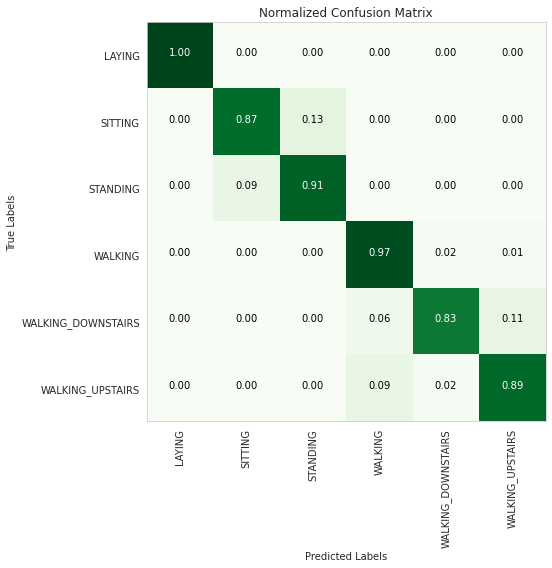



CLASSIFICATION REPORT

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.90      0.87      0.88       491
          STANDING       0.88      0.91      0.90       532
           WALKING       0.87      0.97      0.92       496
WALKING_DOWNSTAIRS       0.95      0.83      0.89       420
  WALKING_UPSTAIRS       0.89      0.89      0.89       471

          accuracy                           0.91      2947
         macro avg       0.92      0.91      0.91      2947
      weighted avg       0.92      0.91      0.91      2947

BEST ESTIMATOR

	RandomForestClassifier(max_depth=11, n_estimators=110)

	
BEST PARAMETERS

	Parameters of best estimator: {'max_depth': 11, 'n_estimators': 110}

	
NO. OF CROSS VALIDATION SPLITS

	Total number of cross validation sets: 5

	
BEST SCORE

	Average cross validated scores of best estimator: 0.920570577653223

	


In [31]:
grid_params = {"n_estimators": np.arange(10,201,20), "max_depth":np.arange(3,15,2)}
rf_clf = RandomForestClassifier()
rf_clf_grid = GridSearchCV(rf_clf, param_grid=grid_params, n_jobs=-1)
rf_clf_grid_results = perform_model(rf_clf_grid, X_train, y_train, X_test, y_test, class_labels=labels)
print_grid_search_attributes(rf_clf_grid_results["model"])

### XGBoost

training the model...
Done 
 

training_time(HH:MM:SS.ms) - 0:00:36.500487 
 

predicting test data
Done 
 

testing_time(HH:MM:SS.ms) - 0:00:00.114648 
 

ACCURACY: 93.89%


CONFUSION MATRIX

[[537   0   0   0   0   0]
 [  0 418  70   0   0   3]
 [  0  25 507   0   0   0]
 [  0   0   0 486   5   5]
 [  0   0   0   9 384  27]
 [  0   0   0  31   5 435]]




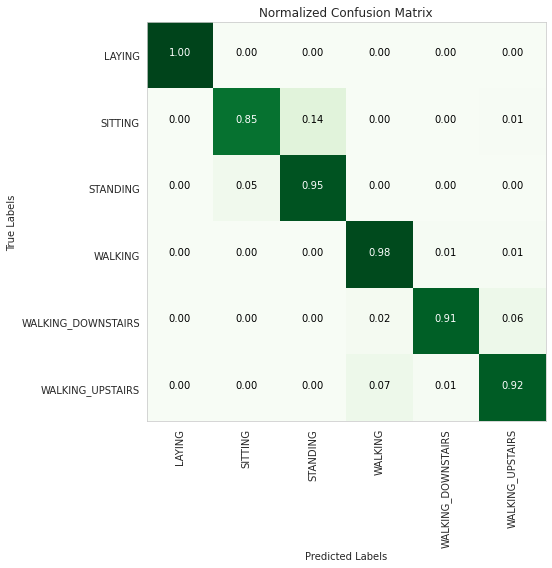



CLASSIFICATION REPORT

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.94      0.85      0.90       491
          STANDING       0.88      0.95      0.91       532
           WALKING       0.92      0.98      0.95       496
WALKING_DOWNSTAIRS       0.97      0.91      0.94       420
  WALKING_UPSTAIRS       0.93      0.92      0.92       471

          accuracy                           0.94      2947
         macro avg       0.94      0.94      0.94      2947
      weighted avg       0.94      0.94      0.94      2947



In [32]:
xgb_clf = XGBClassifier()
xgb_clf_results = perform_model(xgb_clf, X_train, y_train, X_test, y_test, class_labels=labels)

## Comparing all models

In [33]:
print("\n")
print(f"                        Accuracy     Error")
print(f"                        --------     -----")
print(f"Logistic Regression :   {log_reg_grid_results['accuracy'] * 100:.04}%       {100 - log_reg_grid_results['accuracy'] * 100:.04}%")
print(f"LinearSVC           :   {lr_svc_grid_results['accuracy'] * 100:.04}%       {100 - lr_svc_grid_results['accuracy'] * 100:.04}%")
print(f"Kernel SVM          :   {rbf_svm_grid_results['accuracy'] * 100:.04}%       {100 - rbf_svm_grid_results['accuracy'] * 100:.04}%")
print(f"Decision Trees      :   {dt_clf_grid_results['accuracy'] * 100:.04}%       {100 - dt_clf_grid_results['accuracy'] * 100:.04}%")
print(f"Random Forests      :   {rf_clf_grid_results['accuracy'] * 100:.04}%       {100 - rf_clf_grid_results['accuracy'] * 100:.04}%")
print(f"XGBoost             :   {xgb_clf_results['accuracy'] * 100:.04}%       {100 - xgb_clf_results['accuracy'] * 100:.04}%")



                        Accuracy     Error
                        --------     -----
Logistic Regression :   95.89%       4.106%
LinearSVC           :   96.5%       3.495%
Kernel SVM          :   96.27%       3.733%
Decision Trees      :   87.68%       12.32%
Random Forests      :   91.41%       8.585%
XGBoost             :   93.89%       6.108%


- As from visualizing data above with ***t-SNE*** we inferred that *Sitting* and *Standing* were **overlapping** each other.

- Similar is seen while training our ***ML models***. Around **10%** of ***Sitting*** points were misclassified as ***Standing***.

In [34]:
# creating model dictionary to save it for later use
models = dict(logistic_regression=log_reg_grid_results["model"],
              linear_svc=lr_svc_grid_results["model"],
              kernel_svm=rbf_svm_grid_results["model"],
              decision_tree=dt_clf_grid_results["model"],
              random_forests=rf_clf_grid_results["model"],
              xgb_classifier=xgb_clf_results["model"])

save_model(models)

> - For using data set which is *feature engineered* by doamin experts we can use either **Logistic Regression**, **LinearSVC**, or **Kernel SVM** which provides around *95% of accuracy*.
> - This feature engineering by the experts is *not very cost efficient*. We can directly perforn certain *deep learning models* directly on raw data such as **RNNs**.
> - Below is the simple **LSTM model** on the *raw data*.

## LSTM model on raw data

In [35]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x, y, z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [36]:
# utility function to read data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# utility function to load signals
def load_signals(subset):
    signals_data = []
    
    for signal in SIGNALS:
        filename = f"UCI HAR Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt"
        signals_data.append(_read_csv(filename))
        
    return np.transpose(signals_data, (1, 2, 0))

In [37]:
def load_y(subset):
    filename = f"UCI HAR Dataset/{subset}/y_{subset}.txt"
    y = _read_csv(filename)[0]
    
    return pd.get_dummies(y)

In [38]:
def load_data():
    X_train, X_test = load_signals("train"), load_signals("test")
    y_train, y_test = load_y("train"), load_y("test")
    
    return X_train, X_test, y_train, y_test

In [39]:
# initializing parameters
epochs = 30
batch_size = 16
n_hidden = 64

In [40]:
# loading train and test data
X_train, X_test, y_train, y_test = load_data()

- **Defining the architecture of LSTM**

In [41]:
model = Sequential()

model.add(LSTM(n_hidden, input_shape=(128, 9)))

model.add(Dropout(0.5)) # dropout due to less amount of data to train and to generalize well on test set

model.add(Dense(6, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                18944     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________


In [42]:
# compiling the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [43]:
# training the model
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/30
460/460 [==============================] - 5s 11ms/step - loss: 1.3847 - accuracy: 0.3734 - val_loss: 1.3661 - val_accuracy: 0.4048
Epoch 2/30
460/460 [==============================] - 4s 9ms/step - loss: 1.2549 - accuracy: 0.4513 - val_loss: 1.2248 - val_accuracy: 0.4503
Epoch 3/30
460/460 [==============================] - 4s 9ms/step - loss: 1.2320 - accuracy: 0.4505 - val_loss: 1.1577 - val_accuracy: 0.4832
Epoch 4/30
460/460 [==============================] - 4s 9ms/step - loss: 1.0653 - accuracy: 0.5321 - val_loss: 1.0170 - val_accuracy: 0.5517
Epoch 5/30
460/460 [==============================] - 4s 9ms/step - loss: 1.0079 - accuracy: 0.5737 - val_loss: 0.8073 - val_accuracy: 0.6396
Epoch 6/30
460/460 [==============================] - 5s 10ms/step - loss: 0.7272 - accuracy: 0.6685 - val_loss: 0.6992 - val_accuracy: 0.7072
Epoch 7/30
460/460 [==============================] - 4s 9ms/step - loss: 0.6951 - accuracy: 0.6812 - val_loss: 1.0677 - val_accuracy: 0.5643
Epoc

In [44]:
# creating dataframe of loss and accuracy
metrics = pd.DataFrame(model.history.history)

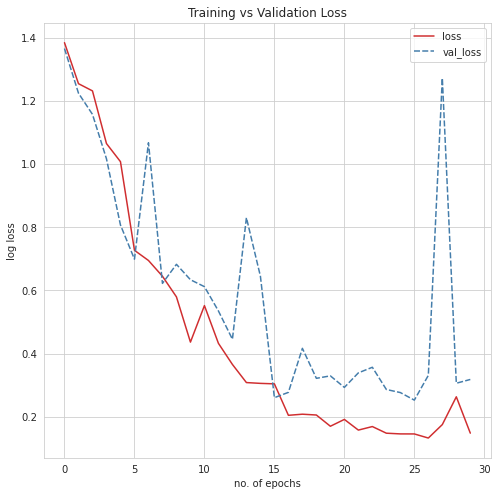

In [45]:
# plotting training loss vs validation loss
plt.figure(figsize=(8, 8))
sns.lineplot(data=metrics[["loss", "val_loss"]])
plt.title("Training vs Validation Loss")
plt.xlabel("no. of epochs")
plt.ylabel("log loss")
plt.show()

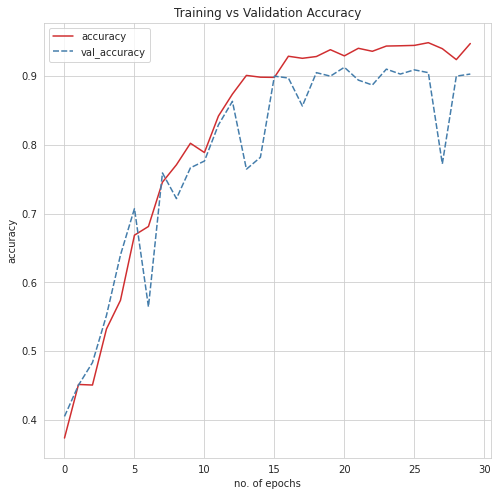

In [46]:
# plotting training accuracy vs validation accuracy
plt.figure(figsize=(8, 8))
sns.lineplot(data=metrics[["accuracy", "val_accuracy"]])
plt.title("Training vs Validation Accuracy")
plt.xlabel("no. of epochs")
plt.ylabel("accuracy")
plt.show()

In [47]:
y_pred = np.argmax(model.predict(X_test), axis=-1) + 1
y_true = pd.read_csv("UCI HAR Dataset/test/y_test.txt", squeeze=True, header=None)
ACTIVITIES = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]

<Figure size 576x576 with 0 Axes>

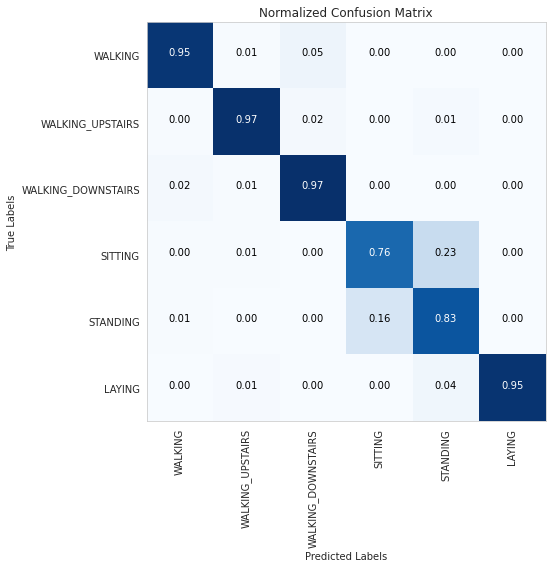

In [48]:
# plotting confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(confusion_matrix(y_true, y_pred), classes=ACTIVITIES, normalize=True)

In [49]:
# classification report
print(f"CLASSIFICATION REPORT\n\n{classification_report(y_true, y_pred)}\n")

CLASSIFICATION REPORT

              precision    recall  f1-score   support

           1       0.97      0.95      0.96       496
           2       0.97      0.97      0.97       471
           3       0.93      0.97      0.95       420
           4       0.81      0.76      0.79       491
           5       0.76      0.83      0.80       532
           6       1.00      0.95      0.98       537

    accuracy                           0.90      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.90      0.90      2947




In [50]:
# saving LSTM model
model.save("./models/lstm_model.h5")

>- By training a simple ***LSTM*** model on raw data we achieve almost *90% accuracy* which is *pretty decent*.
>- If we had *large amount of data* to train a *deep learning model* we could have even *surpassed* the *accuracy* obtained from *classical machine learning algorithms* trained on engineered features by domain experts.

---